In [1]:
!pip install tensorflow

In [2]:
import os
import shutil
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, multiply, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [3]:
!pip install kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahmoudsaadmahmoud","key":"469e6e453f757d251e8c2275853cc1ec"}'}

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU')
except ValueError:
    strategy = tf.distribute.get_strategy()
    print('Running on CPU/GPU')

Running on CPU/GPU


In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

100% 2.03G/2.04G [00:20<00:00, 212MB/s]
100% 2.04G/2.04G [00:20<00:00, 106MB/s]


In [9]:
!unzip plantvillage-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

In [10]:
# Path to the unzipped dataset directory
dataset_dir = "plantvillage dataset/color"

# Create a new folder named "Corn" inside the dataset directory
Corn_dir = os.path.join(dataset_dir, "Corn")
os.makedirs(Corn_dir, exist_ok=True)

# Get a list of all folders in the dataset directory
folders = os.listdir(dataset_dir)

# Move folders starting with "Corn" to the new "Corn" folder
for folder in folders:
    if folder.startswith("Corn"):
        shutil.move(os.path.join(dataset_dir, folder), Corn_dir)

In [11]:
# Function to split data into train and test
def split_data(source, dest, split_size):
    files = []
    for filename in os.listdir(source):
        file = source + "/" + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * split_size)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    test_set = shuffled_set[training_length:]

    for filename in test_set:
        this_file = source + "/" + filename
        destination = dest + "/" + filename
        shutil.move(this_file, destination)

# Separate test images into a new directory for each subfolder in Corn directory
test_split_size = 0.9
corn_test_dir = os.path.join(dataset_dir, "Corn_test")
os.makedirs(corn_test_dir, exist_ok=True)
subfolders = os.listdir(Corn_dir)
for subfolder in subfolders:
    subfolder_path = os.path.join(Corn_dir, subfolder)
    test_subfolder_path = os.path.join(corn_test_dir, subfolder)
    os.makedirs(test_subfolder_path, exist_ok=True)
    split_data(subfolder_path, test_subfolder_path, test_split_size)

In [12]:
input_shape = (224, 224, 3)
num_classes = 4
batch_size = 64
epochs = 20

In [13]:
# Data augmentation helps increase the diversity of training data by applying random transformations to the images, which helps the model generalize better
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [14]:
# Load and split the dataset
dataset_dir = "/content/plantvillage dataset/color/Corn"
# Training data generator for PlantVillage dataset
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


Found 2772 images belonging to 4 classes.


In [15]:
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 692 images belonging to 4 classes.


In [16]:
# Define test data generator (using the validation split from train_datagen)
test_generator = train_datagen.flow_from_directory(
    "/content/plantvillage dataset/color/Corn_test",
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use the validation split for test set
)

Found 76 images belonging to 4 classes.


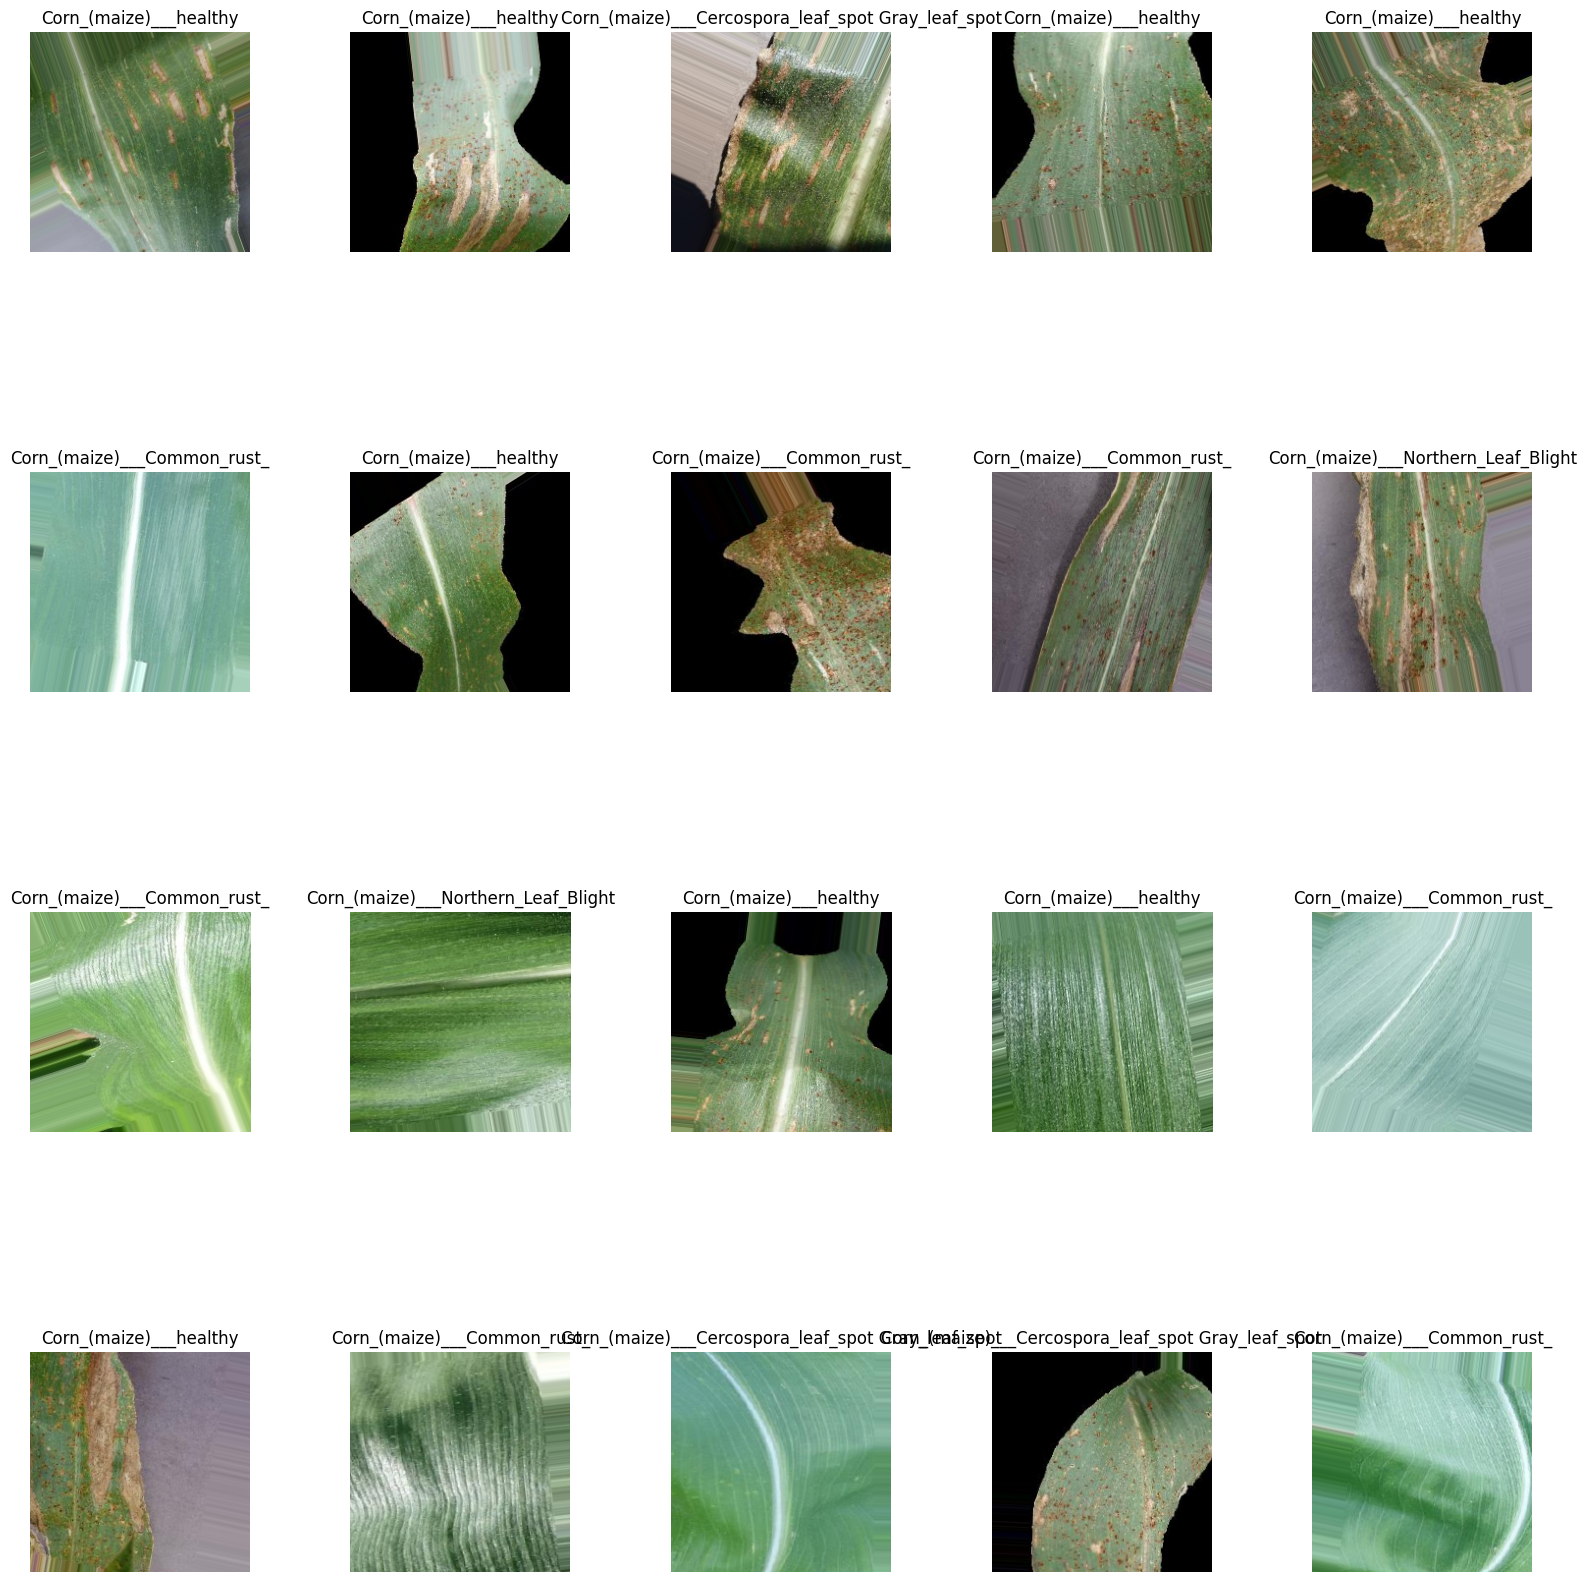

In [17]:
# Display some images from the dataset
sample_images = train_generator.next()[0][:20]
class_labels = train_generator.class_indices
class_names = list(class_labels.keys())

fig, axes = plt.subplots(4, 5, figsize=(20, 20))
axes = axes.ravel()

for i in range(len(sample_images)):
    axes[i].imshow(sample_images[i])
    axes[i].axis('off')
    class_index = np.argmax(train_generator.next()[1][i])
    class_name = class_names[class_index]
    axes[i].set_title(class_name)

plt.subplots_adjust(hspace=1)
plt.show()


In [18]:
# Load pre-trained VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58889256/58889256 [==============================] - 0s 0us/step


In [19]:
for layer in vgg_base.layers:
    layer.trainable = False

In [20]:
# Add attention mechanism
attention = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(vgg_base.output)
attention = Reshape((7, 7))(attention)  # Reshape to match feature map size
attention = tf.expand_dims(attention, axis=-1)  # Add channel dimension
x = multiply([vgg_base.output, attention])
x = GlobalAveragePooling2D()(x)

In [21]:
# Add top layers for classification
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [22]:
# Create the model
model = Model(inputs=vgg_base.input, outputs=predictions)

In [25]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [27]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/20
44/44 [==============================] - 78s 1s/step - loss: 0.8818 - accuracy: 0.6468 - val_loss: 0.5051 - val_accuracy: 0.8280
Epoch 2/20
44/44 [==============================] - 53s 1s/step - loss: 0.4676 - accuracy: 0.8222 - val_loss: 0.3633 - val_accuracy: 0.8772
Epoch 3/20
44/44 [==============================] - 51s 1s/step - loss: 0.3706 - accuracy: 0.8636 - val_loss: 0.2939 - val_accuracy: 0.8916
Epoch 4/20
44/44 [==============================] - 52s 1s/step - loss: 0.3334 - accuracy: 0.8683 - val_loss: 0.2867 - val_accuracy: 0.8960
Epoch 5/20
44/44 [==============================] - 51s 1s/step - loss: 0.3060 - accuracy: 0.8864 - val_loss: 0.2877 - val_accuracy: 0.8844
Epoch 6/20
44/44 [==============================] - 52s 1s/step - loss: 0.2820 - accuracy: 0.8903 - val_loss: 0.2484 - val_accuracy: 0.9017
Epoch 7/20
44/44 [==============================] - 53s 1s/step - loss: 0.2769 - accuracy: 0.8918 - val_loss: 0.2034 - val_accuracy: 0.9335
Epoch 8/20
44/44 [==

In [28]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 4s 3s/step - loss: 0.1177 - accuracy: 0.9605
Test Loss: 0.11768720299005508
Test Accuracy: 0.9605262875556946


In [29]:
# Save the model weights
model.save_weights('VGG_Attention_PV.h5')

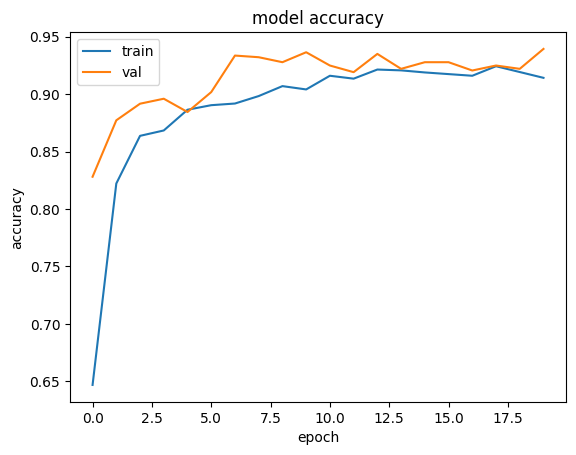

In [30]:
# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

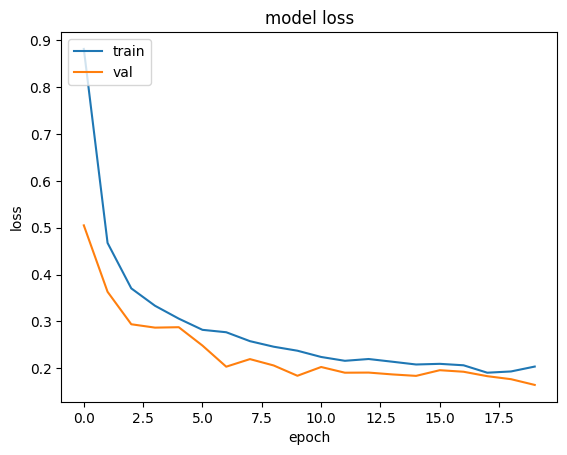

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()